Exercise solutions for the Valence-Bond DMFT
============================

<img src="vb-patching.png" width="240" height="180" border="10">

In [2]:
from pytriqs.gf import *
from pytriqs.operators import *
from triqs_cthyb import Solver
from pytriqs.archive import HDFArchive
import pytriqs.utility.mpi as mpi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Redirect the output of the C++ solver to the notebook
from pytriqs.utility.redirect import *
start_redirect()

Already redirected c++ output


Exercise 1
----------

We create a 2-dimensional grid of k-points ($1000 \times 1000$) covering the Brillouin zone,

and build the corresponding grid of kinetic energies. Finally, we plot the dispersion relation. 

Text(0.5,1,u'Contourplot of the dispersion relation')

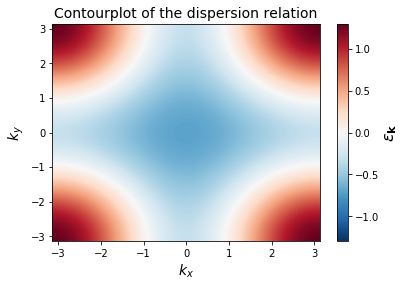

In [4]:
# Parameters
t = 0.25
tp = -0.3*t
U = 10.*t
beta = 200./(4*t)
mu = 0.6155 # Corresponds to a doping of 0.04

# Get the dispersion over the BZ
k_linear = np.linspace(-np.pi, np.pi, 1000, endpoint=False)
kx, ky = np.meshgrid(k_linear, k_linear)
epsk = -2 * t * (np.cos(kx) + np.cos(ky)) - 4 * tp * np.cos(kx) * np.cos(ky)

plt.pcolormesh( k_linear, k_linear, epsk, cmap='RdBu_r', vmin=-1.3, vmax=1.3)
plt.colorbar().set_label(r'$\epsilon_\mathbf{k}$', fontsize=16)
plt.xlabel('$k_x$', fontsize=14)
plt.ylabel('$k_y$', fontsize=14)
plt.title("Contourplot of the dispersion relation", fontsize = 14)

Exercise 2
----------

We calculate the partial density of states for both the even and odd patch using numpy histograms.
We further plot the partial density of states for both patches, which can be directly compared with Fig. 2 of [Phys. Rev. B **80**, 064501 (2009)](https://arxiv.org/abs/0903.2480)

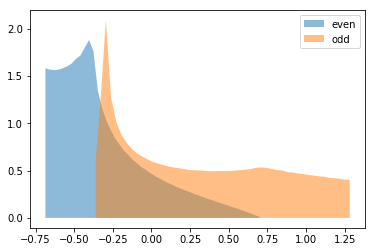

In [5]:
# A mask giving the k points inside the central patch
in_central_patch = (np.abs(kx) < np.pi/np.sqrt(2)) & (np.abs(ky) < np.pi/np.sqrt(2))

# The number of bins for used in the Histogram
n_bins = 50

# Find the partial densities of states associated to the patches
energies, epsilon, rho, delta = {},{}, {}, {}
energies['even'] = np.extract(in_central_patch, epsk)
energies['odd'] = np.extract(np.invert(in_central_patch), epsk)

for patch in ['even','odd']:
    h = np.histogram(energies[patch], bins=n_bins, normed=True)
    epsilon[patch] = 0.5 * (h[1][0:-1] + h[1][1:])
    rho[patch] = h[0]
    delta[patch] = h[1][1]-h[1][0]
    plt.fill_between(epsilon[patch], rho[patch], lw=3, label=patch, alpha=0.5)
    
plt.legend()

Exercise 3
----------

We calculate the local Hamiltonian of the two-site impurity

$H_\mathrm{loc} = U ( n_{1,\uparrow} n_{1,\downarrow} + n_{2,\uparrow} n_{2,\downarrow} )$

in the even-odd basis

$c_{\pm,\sigma} = (c_{1,\sigma} \pm c_{2,\sigma})/\sqrt{2}$

In [6]:
# Calculate the creation/annihilation operators in the site basis by means of the even/odd basis
cn, cn_dag, nn = {}, {}, {}
for spin in ['up','down']:
    cn['1-%s'%spin] = (c('even-%s'%spin,0) + c('odd-%s'%spin,0)) / np.sqrt(2)
    cn['2-%s'%spin] = (c('even-%s'%spin,0) - c('odd-%s'%spin,0)) / np.sqrt(2)
    nn['1-%s'%spin] = dagger(cn['1-%s'%spin]) * cn['1-%s'%spin]
    nn['2-%s'%spin] = dagger(cn['2-%s'%spin]) * cn['2-%s'%spin]

# Local Hamiltonian
h_loc = U * (nn['1-up'] * nn['1-down'] + nn['2-up'] * nn['2-down'])

Exercise 4
----------

We set up the DMFT loop, updating the Weiss field according to

$${\cal G}_0^{-1} = G^{-1} + \Sigma$$

with

$$G_{\pm,\sigma} = \int d\epsilon \, \frac{\rho_{\pm,\sigma}(\epsilon)}{i\omega + \mu - \epsilon - \Sigma_{\pm,\sigma}}$$

In [7]:
# Construct the impurity solver
S = Solver(beta = beta,
           gf_struct = [('even-up',[0]), ('odd-up',[0]), ('even-down',[0]), ('odd-down',[0])], n_l = 100)

# The local lattice Green's function
G = S.G0_iw.copy()

# Initial guess
S.Sigma_iw << mu

# DMFT loop
n_loops = 10
for it in range(n_loops):
    
    # DCA self-consistency - get local lattice G
    G.zero()
    for spin in ['up', 'down']:
        for patch in ['even', 'odd']:
            # Hilbert transform
            for i in range(n_bins):
                G['%s-%s'%(patch,spin)] += rho[patch][i] * delta[patch] * \
                    inverse(iOmega_n + mu - epsilon[patch][i] - S.Sigma_iw['%s-%s'%(patch,spin)])

    # DCA self-consistency - find next impurity G0
    for block, g0 in S.G0_iw:
        g0 << inverse(inverse(G[block]) + S.Sigma_iw[block])

    # Run the solver. The results will be in S.G_tau, S.G_iw and S.G_l
    S.solve(h_int = h_loc,                           # Local Hamiltonian
            n_cycles  = 10000,                       # Number of QMC cycles
            length_cycle = 10,                       # Length of one cycle
            n_warmup_cycles = 1000,                  # Warmup cycles
            measure_G_l = True)                      # Measure G_l
    
    if mpi.is_master_node():
        with HDFArchive("results.h5") as A:
            A['G_iw-%i'%it] = S.G_iw
            A['Sigma_iw-%i'%it] = S.Sigma_iw
            A['G0_iw-%i'%it] = S.G0_iw


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-0.935203*c_dag('even-down',0)*c('even-down',0) + -0.935203*c_dag('even-up',0)*c('even-up',0) + -0.295831*c_dag('odd-down',0)*c('odd-down',0) + -0.295831*c_dag('odd-up',0)*c('odd-up',0) + 1.25*c_dag('even-down',0)*c_dag('even-up',0)*c('odd-up',0)*c('odd-down',0) + 1.25*c_dag('even-down',0)*c_dag('even-up',0)*c('even-up',0)*c('even-down',0) + 1.25*c_dag('even-down',0)*c_dag('odd-up',0)*c('odd-up',0)*c('even-down',0) + -1.25*c_dag('even-down',0)*c_dag('odd-up',0)*c('odd-down',0)*c('even-up',0) + -1.25*c_dag('even-up',0)*c_dag('odd-down',0)*c('odd-up',0)*c('even-down',0) + 1.25*c_dag('even-up',0)*c_dag('odd-down',0)*c('odd-down',0)*c('even-up',0) + 1.25*c_dag('odd-down',0)*c_dag('odd-up',0)*c('odd-up',0)*c('odd-down',0) + 1.25*c_dag('odd-down',0)*c_dag('odd-up',0)*c('even-up',0)*c('even-down',0)
Using autopartition algorithm to partition the local Hilbert


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-0.935203*c_dag('even-down',0)*c('even-down',0) + -0.935203*c_dag('even-up',0)*c('even-up',0) + -0.295831*c_dag('odd-down',0)*c('odd-down',0) + -0.295831*c_dag('odd-up',0)*c('odd-up',0) + 1.25*c_dag('even-down',0)*c_dag('even-up',0)*c('odd-up',0)*c('odd-down',0) + 1.25*c_dag('even-down',0)*c_dag('even-up',0)*c('even-up',0)*c('even-down',0) + 1.25*c_dag('even-down',0)*c_dag('odd-up',0)*c('odd-up',0)*c('even-down',0) + -1.25*c_dag('even-down',0)*c_dag('odd-up',0)*c('odd-down',0)*c('even-up',0) + -1.25*c_dag('even-up',0)*c_dag('odd-down',0)*c('odd-up',0)*c('even-down',0) + 1.25*c_dag('even-up',0)*c_dag('odd-down',0)*c('odd-down',0)*c('even-up',0) + 1.25*c_dag('odd-down',0)*c_dag('odd-up',0)*c('odd-up',0)*c('odd-down',0) + 1.25*c_dag('odd-down',0)*c_dag('odd-up',0)*c('even-up',0)*c('even-down',0)
Using autopartition algorithm to partition the local Hilbert


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-0.935203*c_dag('even-down',0)*c('even-down',0) + -0.935203*c_dag('even-up',0)*c('even-up',0) + -0.295831*c_dag('odd-down',0)*c('odd-down',0) + -0.295831*c_dag('odd-up',0)*c('odd-up',0) + 1.25*c_dag('even-down',0)*c_dag('even-up',0)*c('odd-up',0)*c('odd-down',0) + 1.25*c_dag('even-down',0)*c_dag('even-up',0)*c('even-up',0)*c('even-down',0) + 1.25*c_dag('even-down',0)*c_dag('odd-up',0)*c('odd-up',0)*c('even-down',0) + -1.25*c_dag('even-down',0)*c_dag('odd-up',0)*c('odd-down',0)*c('even-up',0) + -1.25*c_dag('even-up',0)*c_dag('odd-down',0)*c('odd-up',0)*c('even-down',0) + 1.25*c_dag('even-up',0)*c_dag('odd-down',0)*c('odd-down',0)*c('even-up',0) + 1.25*c_dag('odd-down',0)*c_dag('odd-up',0)*c('odd-up',0)*c('odd-down',0) + 1.25*c_dag('odd-down',0)*c_dag('odd-up',0)*c('even-up',0)*c('even-down',0)
Using autopartition algorithm to partition the local Hilbert